In [1]:
import functools
from functools import partial
import itertools
import logging
import math
import os
import pickle
import sys
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pingouin as pg
import seaborn as sns
import yaml
#import pingouin as pg

%load_ext autoreload
%autoreload 2

%matplotlib inline

sns.set_context("poster")
sns.set(rc={"figure.figsize": (16, 12.0)})
sns.set_style("whitegrid")

import numpy as np
import pandas as pd
from scipy.stats import kendalltau, rankdata, spearmanr, pearsonr, ttest_rel
import torch.nn.functional as F

pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

logging.basicConfig(level=logging.INFO, stream=sys.stdout)

In [2]:
from lda4rec.datasets import Interactions, DataLoader, random_train_test_split, MOVIELENS_1M,MetaData, get_dataset, items_per_user_train_test_split
import lda4rec.evaluations as lda_eval
from lda4rec.estimators import MFEst, PopEst, LDA4RecEst, SNMFEst
from lda4rec.utils import process_ids, cmp_ranks, Config, split_along_dim_apply, plot_cat
from lda4rec import lda

In [3]:
import pyro
import pyro.distributions as dist
import pyro.optim as optim
import torch
from pyro.distributions import constraints
from pyro.infer import SVI, Predictive, Trace_ELBO, TraceEnum_ELBO, config_enumerate

In [4]:
import neptune.new as neptune
# init dummy neptune to avoid problems with logging
neptune.init(mode='offline') 

offline/07b41d80-71d7-44e2-9bf7-15bad5614fa9
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [5]:
from icecream import ic, install

install()
# configure icecream
def ic_str(obj):
    if hasattr(obj, "shape"):
        return f"{obj} "  #
    else:
        return str(obj)

In [6]:
ic.configureOutput(argToStringFunction=ic_str)

## Interpretation

In [7]:
md = MetaData.from_movielens_1m()

**Careful** experiment ids changed

In [8]:
cfg = Config(Path('../configs/exp_41.yaml'))
exp_cfg = cfg["experiment"]

In [9]:
exp_cfg

{'dataset': 'movielens-1m',
 'dataset_seed': 1729,
 'est_params': {'batch_size': 256,
  'embedding_dim': 16,
  'learning_rate': 0.001,
  'n_iter': 200},
 'estimator': 'MFEst',
 'interaction_pivot': 0,
 'max_user_interactions': 200,
 'min_user_interactions': 20,
 'model_seed': 666,
 'train_test_split': 'items_per_user_train_test_split'}

In [10]:
data_rng = np.random.default_rng(exp_cfg["dataset_seed"])
data = get_dataset(exp_cfg["dataset"], data_dir=cfg["main"]["data_path"])
data.implicit_(exp_cfg["interaction_pivot"])  # implicit feedback
data.max_user_interactions_(exp_cfg["max_user_interactions"], rng=data_rng)
data.min_user_interactions_(exp_cfg["min_user_interactions"])

assert exp_cfg["train_test_split"] == "items_per_user_train_test_split"

train, test = items_per_user_train_test_split(data, n_items_per_user=10, rng=data_rng)

In [11]:
est = MFEst(**exp_cfg["est_params"])
est.load("../models/exp_25_MFEst_2021-12-28_18:02:01.model", data)

<MFEst: MFNet(
  (user_embeddings): ScaledEmbedding(6040, 16)
  (item_embeddings): ScaledEmbedding(3706, 16)
  (item_biases): ZeroEmbedding(3706, 1)
)>

In [12]:
v, t, h, b = est.get_lda_params()

## Cohort overlap of N most likely values of different cohorts

In [13]:
corr = lda_eval.cohort_top_n_ranking_corr(h, n=100, alpha=0.05)

<AxesSubplot:>

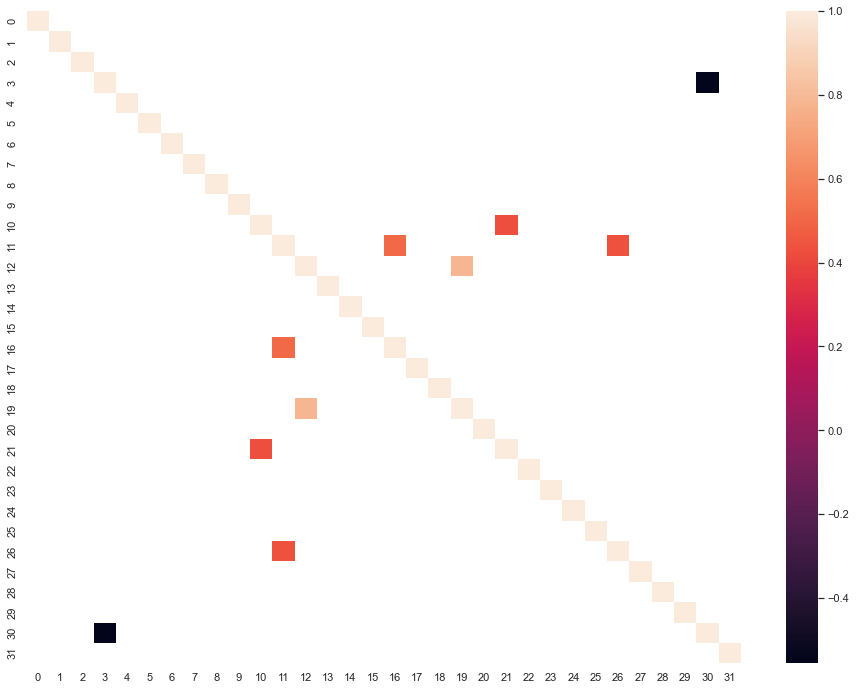

In [14]:
sns.heatmap(corr)

<AxesSubplot:ylabel='Count'>

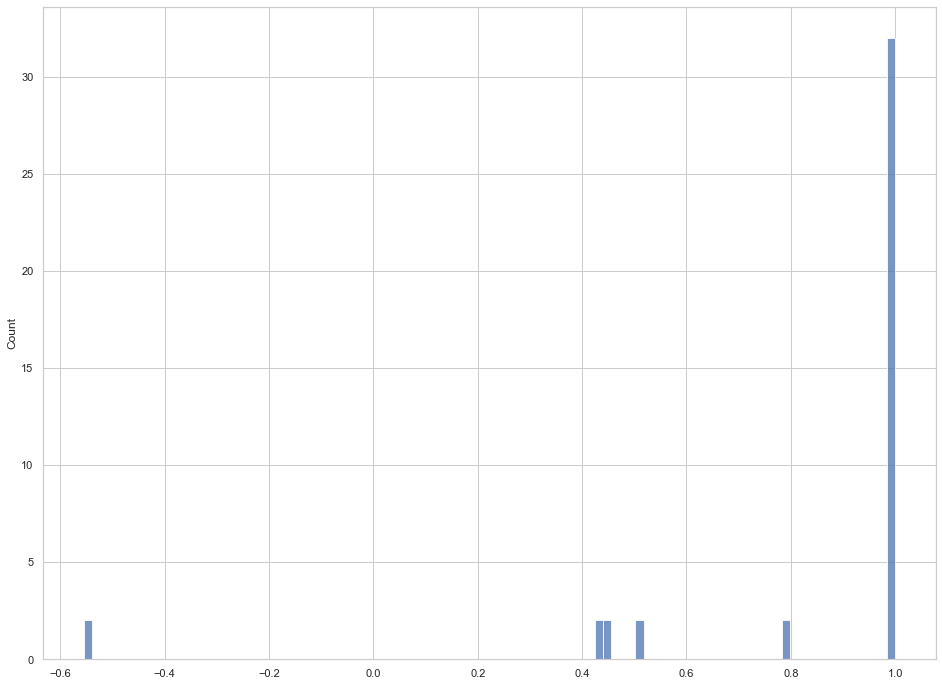

In [15]:
sns.histplot(corr.flatten(), bins=100)

## Popularity Comparison

In [16]:
corr = lda_eval.popularity_ranking_corr(data, b)

In [17]:
corr

KendalltauResult(correlation=0.6504477054053042, pvalue=0.0)

Quite strong according to http://polisci.usca.edu/apls301/Text/Chapter%2012.%20Significance%20and%20Measures%20of%20Association.htm

## Conformity to Popularity

In [19]:
emp_pops = lda_eval.get_empirical_pops(data)
lda_eval.conformity_interaction_pop_ranking_corr(emp_pops, (1/t).numpy(), data)

KendalltauResult(correlation=0.225103022318335, pvalue=1.647099560477261e-151)

In [20]:
lda_eval.conformity_interaction_pop_ranking_corr(b, (1/t).numpy(), data)

KendalltauResult(correlation=0.3809248415075895, pvalue=0.0)

do this on test set!

## User Finger Printing and Interaction correlation

In [21]:
user_ids, good_twins, bad_twins, rnd_twins = lda_eval.find_good_bad_rnd_twins(v, n_users=100)

In [22]:
good_jacs = lda_eval.get_twin_jacs(user_ids, good_twins, data)
bad_jacs = lda_eval.get_twin_jacs(user_ids, bad_twins, data)
rnd_jacs = lda_eval.get_twin_jacs(user_ids, rnd_twins, data)

In [23]:
pg.ttest(good_jacs, bad_jacs, paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,15.739538,99,two-sided,1.067841e-28,"[0.1, 0.13]",2.180326,3.173e+25,1.0


In [24]:
pg.ttest(good_jacs, rnd_jacs, paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,8.922752,99,two-sided,2.439131e-14,"[0.06, 0.1]",1.325679,2.873e+11,1.0
